# 3.2.6 [Challenge: Random Forest vs. Decision Tree](https://courses.thinkful.com/data-201v1/project/3.2.6)

Now that you've learned about random forests and decision trees let's do an exercise in accuracy. You know that random forests are basically a collection of decision trees. But how do the accuracies of the two models compare?

So here's what you should do. Pick a dataset. It could be one you've worked with before or it could be a new one. Then build the best decision tree you can.

Now try to match that with the simplest random forest you can. For our purposes measure simplicity with runtime. Compare that to the runtime of the decision tree. This is imperfect but just go with it.

Hopefully out of this you'll see the power of random forests, but also their potential costs. Remember, in the real world you won't necessarily be dealing with thousands of rows. It could be millions, billions, or even more.

Submit a link to your models below.

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

%matplotlib inline

from sklearn import ensemble, tree
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from IPython.display import Image
import pydotplus
import graphviz

In [134]:
dt_call = pd.read_csv('unit_3_data/telco_churn_dataset.csv')
# Minutes/Call
dt_call['TotalMinutes'] = dt_call['TotalDayMinutes'] + dt_call['TotalEveMinutes'] + dt_call['TotalNightMinutes']
dt_call['MinutesPerCall'] = dt_call['TotalMinutes']/dt_call['TotalCall']

# Percent of Calls at night
dt_call['PercentNightCalls'] = dt_call['TotalNightCalls']/dt_call['TotalCall']
dt_call['PercentDayCalls'] = dt_call['TotalDayCalls']/dt_call['TotalCall']

# New subscriber flag (in first cycle of contract)
dt_call['tenure_num'] = np.where(dt_call['tenure']==0, 0.0, 
                                 np.where(dt_call['Contract']=='One year', dt_call['tenure']/12.0,
                                          np.where(dt_call['Contract']=='Two year', dt_call['tenure']/24.0,
                                                   dt_call['tenure']
                                                  )))
dt_call['new_sub_flag'] = np.where(dt_call['tenure_num']<=1, 1, 0)
dt_call['messages'] = np.where(dt_call['NumbervMailMessages'] >=1, 1, 0)

dt_call['Churn'] = np.where(dt_call['Churn']== 'Yes',1,0)

dt_call = dt_call[['Churn',   
                   'MultipleLines', 
                   'TotalIntlCalls', 
                   'TotalCall', 'CustomerServiceCalls',
                   'tenure','MinutesPerCall', 'tenure_num', 
                   'PercentDayCalls', 'PercentNightCalls', 
                   'new_sub_flag', 'SeniorCitizen', 'InternetService',
                   'Contract', 'PaperlessBilling' ]]

In [135]:
df_majority = dt_call[dt_call.Churn==0]
df_minority = dt_call[dt_call.Churn==1]

# Downsample Majority Class
df_majority_downsampled = resample(df_majority,
                                  replace=False,   # sample without replacement
                                  n_samples=483,   # to match minority class
                                  random_state=123 # reproducible results
                                  )

# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

# New Class Counts
df_downsampled.Churn.value_counts()

1    483
0    483
Name: Churn, dtype: int64

### Decision Tree

In [136]:
dt_call.groupby('Churn').count()

,MultipleLines,TotalIntlCalls,TotalCall,CustomerServiceCalls,tenure,MinutesPerCall,tenure_num,PercentDayCalls,PercentNightCalls,new_sub_flag,SeniorCitizen,InternetService,Contract,PaperlessBilling
Churn,,,,,,,,,,,,,,
0,2850,2850,2850,2850,2850,2850,2850,2850,2850,2850,2850,2850,2850,2850
1,483,483,483,483,483,483,483,483,483,483,483,483,483,483


--- 0.15983176231384277 seconds ---


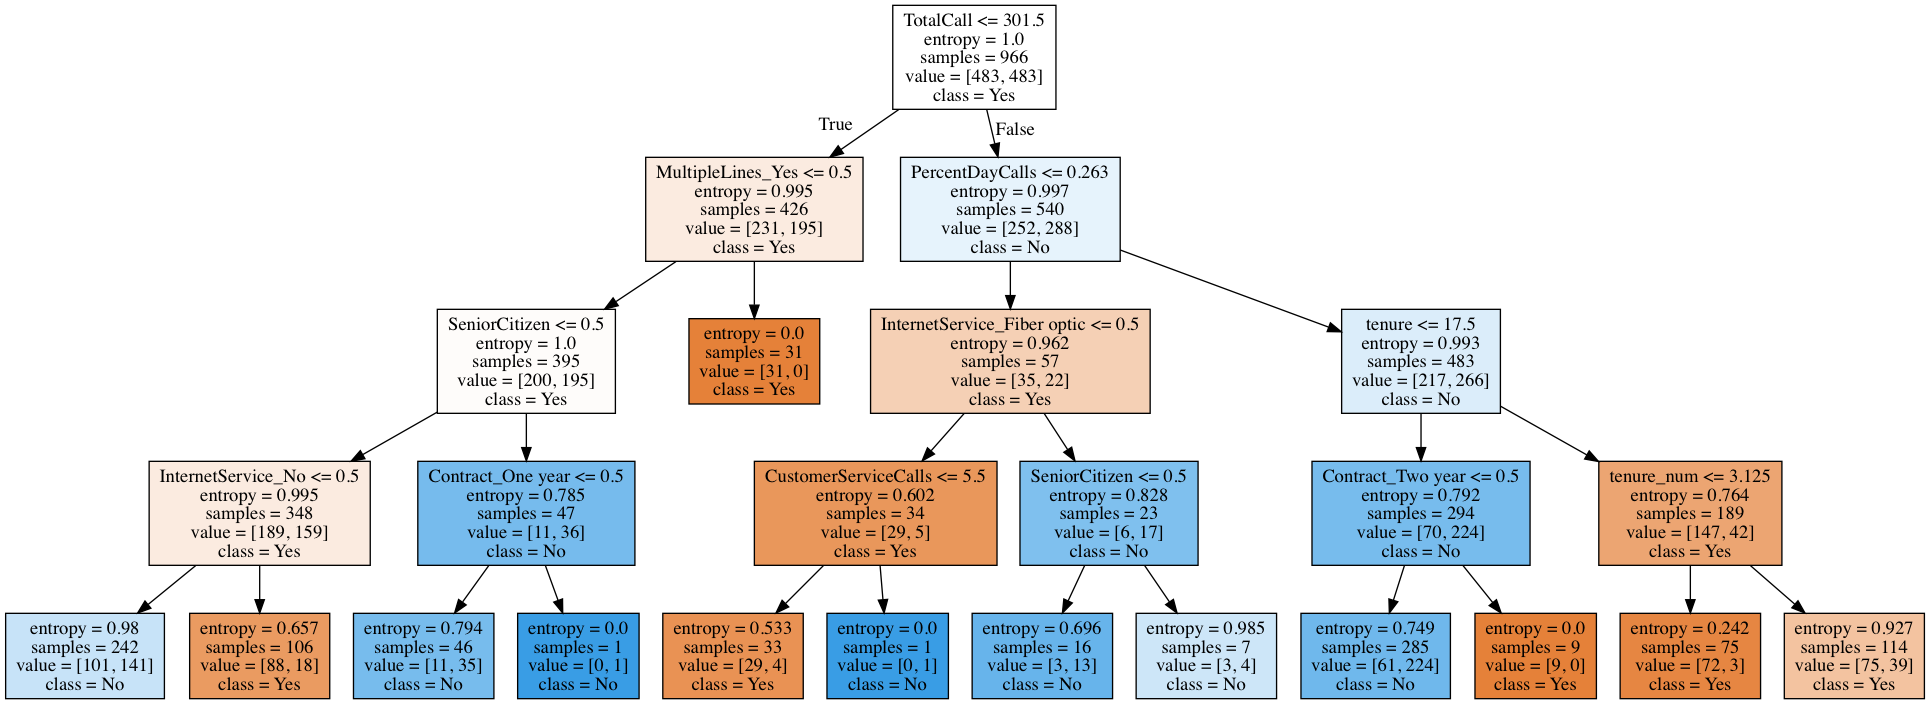

In [124]:
import time
start_time = time.time()


churn = df_downsampled['Churn']
customers = df_downsampled.drop('Churn', axis=1)
customers = pd.get_dummies(customers)

decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=4
)

decision_tree.fit(customers, churn)

# Render Tree
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=customers.columns,
    class_names=['Yes', 'No'],
    filled=True
)

graph = pydotplus.graph_from_dot_data(dot_data)
print("--- %s seconds ---" % (time.time() - start_time))
Image(graph.create_png())


In [115]:
pd.DataFrame(data={'feature':customers.columns,
                   'importance':decision_tree.feature_importances_}).sort_values(
    by='importance',ascending=False)

,feature,importance
15,Contract_Month-to-month,0.727358
5,tenure_num,0.139883
12,InternetService_DSL,0.031688
16,Contract_One year,0.024279
10,MultipleLines_No,0.020512
19,PaperlessBilling_Yes,0.016546
7,PercentNightCalls,0.012371
18,PaperlessBilling_No,0.008007
8,new_sub_flag,0.007437
1,TotalCall,0.006472


In [116]:
accuracy_score(decision_tree.predict(customers), churn)

0.7546583850931677

In [117]:
cross_val_score(decision_tree,X=customers,y=churn, cv=10)

array([0.58163265, 0.62244898, 0.67346939, 0.79166667, 0.6875    ,
       0.72916667, 0.61458333, 0.71875   , 0.70833333, 0.72916667])

In [118]:
churn_all = dt_call['Churn']
customers_all = dt_call.drop('Churn', axis=1)
customers_all = pd.get_dummies(customers_all)

accuracy_score(y_pred=decision_tree.predict(customers_all),y_true=churn_all)

0.7131713171317132

In [119]:
confusion_matrix(y_true=churn_all, y_pred=decision_tree.predict(customers_all))

array([[1988,  862],
       [  94,  389]])

In [120]:
confusion_matrix(churn, decision_tree.predict(customers))

array([[340, 143],
       [ 94, 389]])

In [138]:
rfc = ensemble.RandomForestClassifier(max_depth=3,
                                     criterion='entropy')

In [139]:
rfc.fit(customers, churn)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [140]:
rfc.predict(X=customers)

array([0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,

# Random Forest

In [150]:
start_time = time.time()

churn = df_downsampled['Churn']
customers = df_downsampled.drop('Churn', axis=1)
customers = pd.get_dummies(customers)


rfc = ensemble.RandomForestClassifier(max_depth=3,
                                     criterion='entropy')
rfc.fit(customers, churn)
prediction = rfc.predict(customers)
print(cross_val_score(rfc, X=customers, y=churn, cv=10))
print(accuracy_score(prediction, churn))
print("--- %s seconds ---" % (time.time() - start_time))

[0.74489796 0.80612245 0.7755102  0.80208333 0.76041667 0.83333333
 0.77083333 0.85416667 0.82291667 0.71875   ]
0.7939958592132506
--- 0.17984414100646973 seconds ---


In [151]:
churn_all = dt_call['Churn']
customers_all = dt_call.drop('Churn', axis=1)
customers_all = pd.get_dummies(customers_all)

predict_all = rfc.predict(customers_all)
print(cross_val_score(rfc, X=customers_all, y=churn_all, cv=10))
print(accuracy_score(predict_all, churn_all))

[0.86227545 0.86826347 0.85329341 0.85585586 0.86486486 0.86486486
 0.85585586 0.85585586 0.86186186 0.85585586]
0.7191719171917191
